# Supervised Learning: Predicting Summary Quality from LLM Judge Features

This notebook trains and compares multiple supervised ML models to predict whether a summarization
output will **PASS** or **FAIL** quality review, using 8 binary features derived from an LLM judge's
per-criterion assessments.

**Dataset**: `summarization_frank_features.csv` — 768 samples from the FRANK benchmark, scored by
Claude 3.5 Sonnet on 8 quality criteria.

**Target**: `label` (0 = FAIL, 1 = PASS)

**Models compared**:
1. Logistic Regression (unregularized)
2. Logistic Regression with L1 (Lasso)
3. Logistic Regression with L2 (Ridge)
4. Decision Tree
5. Random Forest
6. Gradient Boosted Trees
7. Neural Network (MLP)

**Goals**: Identify which model best predicts quality labels, understand which judge criteria are most
predictive, and evaluate whether a lightweight classifier can supplement the full LLM judge.

In [28]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    cross_val_predict,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from scipy import stats

sns.set_theme(style="whitegrid", palette="colorblind", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

RANDOM_STATE = 229

## 1. Data Loading and Exploratory Data Analysis

In [29]:
DATA_PATH = Path("./evals_benchmark_datasets/summarization_frank_features.csv")
df = pd.read_csv(DATA_PATH)

FEATURE_COLS = [
    "salience",
    "coverage",
    "faithfulness",
    "attribution_specificity",
    "entity_number_fidelity",
    "coherence",
    "conciseness",
    "non_contradiction",
]
TARGET = "label"

X = df[FEATURE_COLS]
y = df[TARGET]

print(f"Dataset shape: {df.shape}")
print(f"Features: {FEATURE_COLS}")
print(f"\nClass distribution:")
print(y.value_counts().rename({0: "FAIL (0)", 1: "PASS (1)"}))
print(f"\nClass balance: {y.mean():.1%} PASS / {1 - y.mean():.1%} FAIL")
print(f"\nMissing values: {X.isnull().sum().sum()}")
print(f"\nFeature value counts (all should be binary 0/1):")
for col in FEATURE_COLS:
    print(f"  {col}: {sorted(df[col].unique())}")

Dataset shape: (768, 11)
Features: ['salience', 'coverage', 'faithfulness', 'attribution_specificity', 'entity_number_fidelity', 'coherence', 'conciseness', 'non_contradiction']

Class distribution:
label
FAIL (0)    501
PASS (1)    267
Name: count, dtype: int64

Class balance: 34.8% PASS / 65.2% FAIL

Missing values: 0

Feature value counts (all should be binary 0/1):
  salience: [0, 1]
  coverage: [0, 1]
  faithfulness: [0, 1]
  attribution_specificity: [0, 1]
  entity_number_fidelity: [0, 1]
  coherence: [0, 1]
  conciseness: [0, 1]
  non_contradiction: [0, 1]


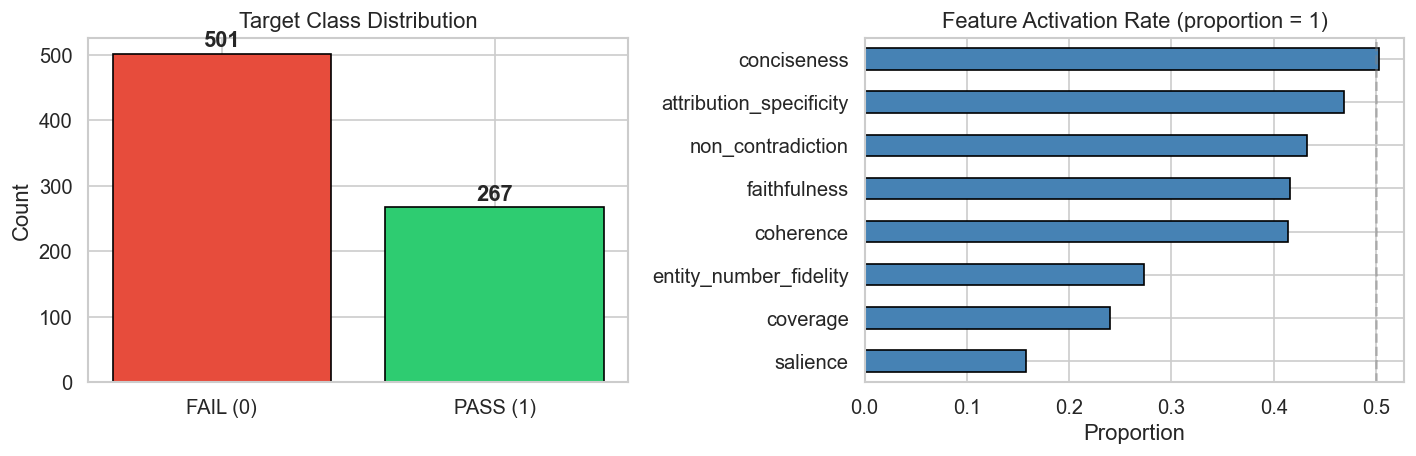

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class distribution
counts = y.value_counts()
bars = axes[0].bar(
    ["FAIL (0)", "PASS (1)"],
    [counts[0], counts[1]],
    color=["#e74c3c", "#2ecc71"],
    edgecolor="black",
)
for bar, count in zip(bars, [counts[0], counts[1]]):
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 5,
        str(count),
        ha="center",
        va="bottom",
        fontweight="bold",
    )
axes[0].set_title("Target Class Distribution")
axes[0].set_ylabel("Count")

# Feature activation rates
feature_means = X.mean().sort_values(ascending=True)
feature_means.plot.barh(ax=axes[1], color="steelblue", edgecolor="black")
axes[1].set_title("Feature Activation Rate (proportion = 1)")
axes[1].set_xlabel("Proportion")
axes[1].axvline(x=0.5, color="gray", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

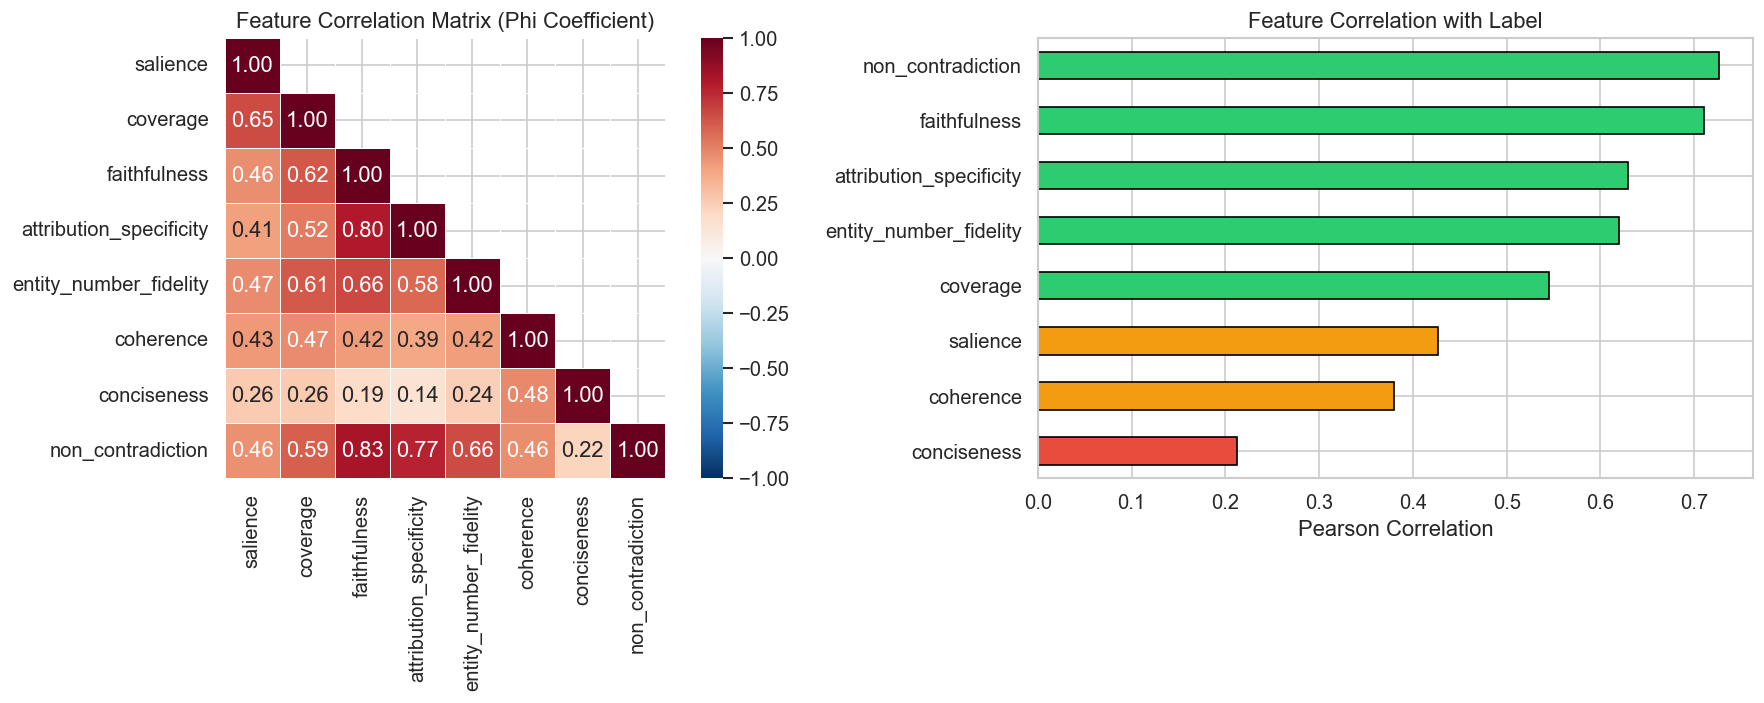

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Feature correlation heatmap (Phi coefficient for binary variables)
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    ax=axes[0],
    square=True,
    linewidths=0.5,
)
axes[0].set_title("Feature Correlation Matrix (Phi Coefficient)")

# Correlation of each feature with the target
corr_with_target = X.corrwith(y).sort_values(ascending=True)
colors = [
    "#e74c3c" if v < 0.3 else "#f39c12" if v < 0.5 else "#2ecc71"
    for v in corr_with_target
]
corr_with_target.plot.barh(ax=axes[1], color=colors, edgecolor="black")
axes[1].set_title("Feature Correlation with Label")
axes[1].set_xlabel("Pearson Correlation")
axes[1].axvline(x=0, color="black", linewidth=0.5)

plt.tight_layout()
plt.show()

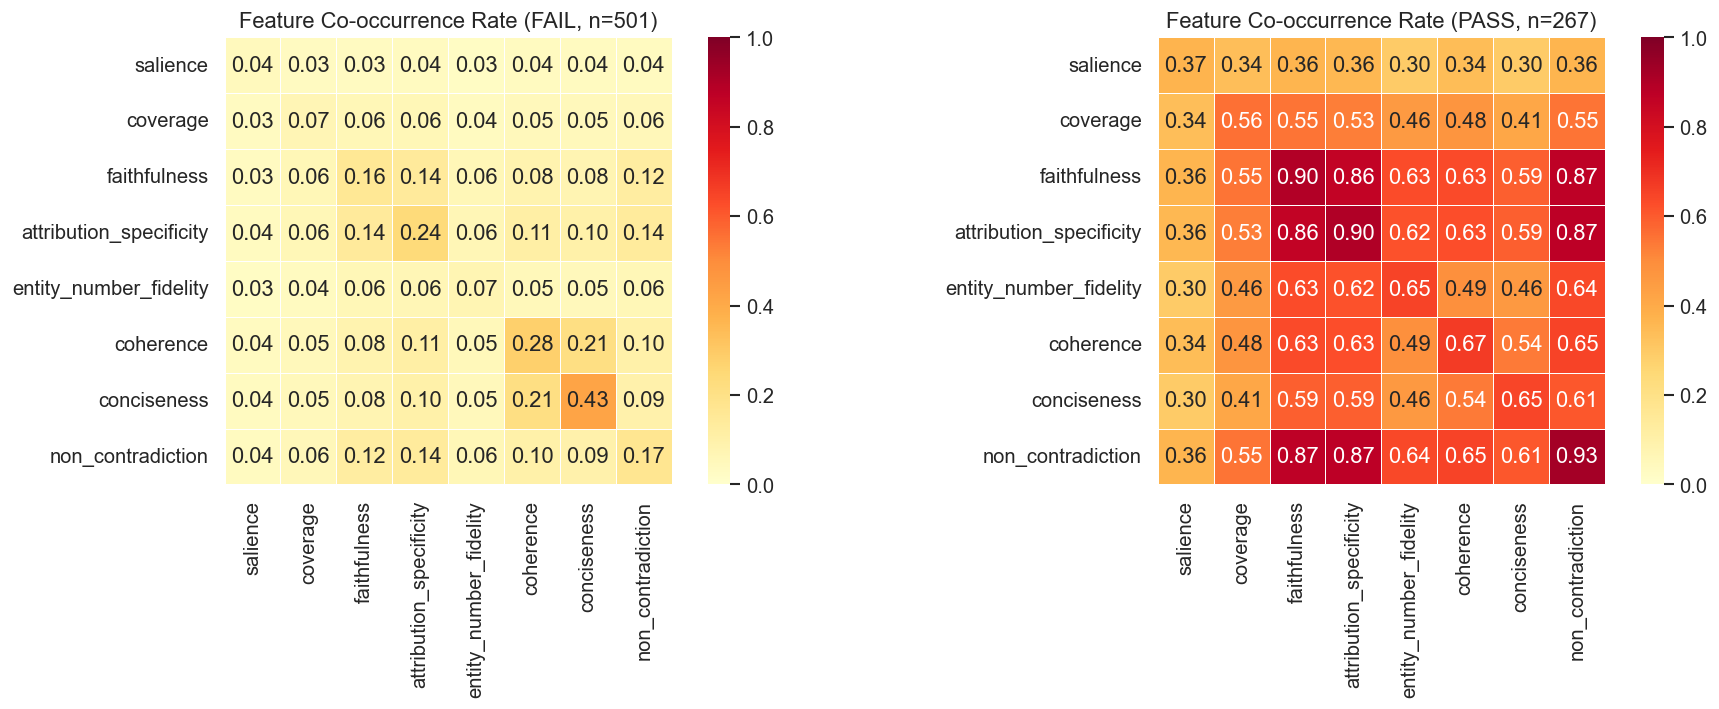

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (label_val, label_name) in enumerate([(0, "FAIL"), (1, "PASS")]):
    subset = X[y == label_val]
    co_occurrence = subset.T.dot(subset) / len(subset)
    sns.heatmap(
        co_occurrence,
        annot=True,
        fmt=".2f",
        cmap="YlOrRd",
        ax=axes[idx],
        square=True,
        linewidths=0.5,
        vmin=0,
        vmax=1,
    )
    axes[idx].set_title(
        f"Feature Co-occurrence Rate ({label_name}, n={len(subset)})"
    )

plt.tight_layout()
plt.show()

## 2. Train/Test Split

Stratified 80/20 split to preserve class balance. The test set is held out until the final evaluation.
All model selection uses cross-validation on the training set only.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"  FAIL: {(y_train == 0).sum()} ({(y_train == 0).mean():.1%})")
print(f"  PASS: {(y_train == 1).sum()} ({(y_train == 1).mean():.1%})")
print(f"\nTest set:     {X_test.shape[0]} samples")
print(f"  FAIL: {(y_test == 0).sum()} ({(y_test == 0).mean():.1%})")
print(f"  PASS: {(y_test == 1).sum()} ({(y_test == 1).mean():.1%})")

Training set: 614 samples
  FAIL: 401 (65.3%)
  PASS: 213 (34.7%)

Test set:     154 samples
  FAIL: 100 (64.9%)
  PASS: 54 (35.1%)


## 3. Cross-Validation Strategy and Model Definitions

**CV**: Stratified 5-fold (gives ~123 samples/fold, sufficient for 35% minority class).

**No feature scaling** needed — all features are binary (0/1).

**Class imbalance** handled via `class_weight='balanced'` where supported by the estimator.

In [34]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

SCORING = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

MODELS = {
    "Logistic (No Reg.)": LogisticRegression(
        penalty=None,
        solver="lbfgs",
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    ),
    "Logistic (L1)": LogisticRegression(
        penalty="l1",
        C=1.0,
        solver="saga",
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    ),
    "Logistic (L2)": LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=4,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
    "Gradient Boosted": GradientBoostingClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
    ),
    "Neural Net (MLP)": MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.15,
        random_state=RANDOM_STATE,
    ),
}

print(f"Models to evaluate: {list(MODELS.keys())}")
print(f"CV strategy: {cv}")

Models to evaluate: ['Logistic (No Reg.)', 'Logistic (L1)', 'Logistic (L2)', 'Decision Tree', 'Random Forest', 'Gradient Boosted', 'Neural Net (MLP)']
CV strategy: StratifiedKFold(n_splits=5, random_state=229, shuffle=True)


## 4. Cross-Validation Results

In [35]:
cv_results = {}

for name, model in MODELS.items():
    print(f"Evaluating {name}...", end=" ")
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=SCORING,
        return_train_score=False,
        n_jobs=-1,
    )
    cv_results[name] = {
        metric: scores[f"test_{metric}"] for metric in SCORING
    }
    mean_f1 = scores["test_f1"].mean()
    print(f"F1 = {mean_f1:.3f} (\u00b1 {scores['test_f1'].std():.3f})")

print("\nAll models evaluated.")

Evaluating Logistic (No Reg.)... F1 = 0.827 (± 0.031)
Evaluating Logistic (L1)... F1 = 0.827 (± 0.031)
Evaluating Logistic (L2)... F1 = 0.827 (± 0.031)
Evaluating Decision Tree... F1 = 0.828 (± 0.030)
Evaluating Random Forest... F1 = 0.829 (± 0.035)
Evaluating Gradient Boosted... F1 = 0.804 (± 0.052)
Evaluating Neural Net (MLP)... F1 = 0.825 (± 0.043)

All models evaluated.


In [36]:
# --- Simple baselines (no learned parameters) ---
# Compute metrics within the same CV folds for fair comparison.

BASELINE_NAMES = ["Baseline (Avg Features)", "Baseline (Salience)"]

# Store per-fold predictions for confusion matrices and ROC curves later
baseline_cv_preds = {name: {"y_true": [], "y_pred": [], "y_proba": []} for name in BASELINE_NAMES}

for name in BASELINE_NAMES:
    fold_metrics = {metric: [] for metric in SCORING}

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]

        if name == "Baseline (Avg Features)":
            y_proba_fold = X_val_fold[FEATURE_COLS].mean(axis=1).values
            y_pred_fold = (y_proba_fold >= 0.5).astype(int)
        else:  # Baseline (Salience)
            y_proba_fold = X_val_fold["salience"].values.astype(float)
            y_pred_fold = X_val_fold["salience"].values.astype(int)

        baseline_cv_preds[name]["y_true"].append(y_val_fold.values)
        baseline_cv_preds[name]["y_pred"].append(y_pred_fold)
        baseline_cv_preds[name]["y_proba"].append(y_proba_fold)

        fold_metrics["accuracy"].append(accuracy_score(y_val_fold, y_pred_fold))
        fold_metrics["precision"].append(precision_score(y_val_fold, y_pred_fold, zero_division=0))
        fold_metrics["recall"].append(recall_score(y_val_fold, y_pred_fold, zero_division=0))
        fold_metrics["f1"].append(f1_score(y_val_fold, y_pred_fold, zero_division=0))
        fold_metrics["roc_auc"].append(roc_auc_score(y_val_fold, y_proba_fold))

    cv_results[name] = {metric: np.array(vals) for metric, vals in fold_metrics.items()}
    mean_f1 = cv_results[name]["f1"].mean()
    print(f"Evaluating {name}... F1 = {mean_f1:.3f} (\u00b1 {cv_results[name]['f1'].std():.3f})")

# Concatenate per-fold predictions into full arrays
for name in BASELINE_NAMES:
    baseline_cv_preds[name]["y_true"] = np.concatenate(baseline_cv_preds[name]["y_true"])
    baseline_cv_preds[name]["y_pred"] = np.concatenate(baseline_cv_preds[name]["y_pred"])
    baseline_cv_preds[name]["y_proba"] = np.concatenate(baseline_cv_preds[name]["y_proba"])

Evaluating Baseline (Avg Features)... F1 = 0.801 (± 0.026)
Evaluating Baseline (Salience)... F1 = 0.508 (± 0.085)


In [37]:
rows = []
for name, scores in cv_results.items():
    row = {"Model": name}
    for metric in SCORING:
        vals = scores[metric]
        row[f"{metric} (mean)"] = vals.mean()
        row[f"{metric} (std)"] = vals.std()
    rows.append(row)

results_df = pd.DataFrame(rows).set_index("Model")

display_cols = [f"{m} (mean)" for m in SCORING]
styled = (
    results_df[display_cols]
    .style.format("{:.3f}")
    .highlight_max(axis=0, color="#c6efce")
    .highlight_min(axis=0, color="#ffc7ce")
)
styled

,accuracy (mean),precision (mean),recall (mean),f1 (mean),roc_auc (mean)
Model,,,,,
Logistic (No Reg.),0.870,0.767,0.901,0.827,0.924
Logistic (L1),0.870,0.767,0.901,0.827,0.924
Logistic (L2),0.870,0.766,0.901,0.827,0.923
Decision Tree,0.868,0.759,0.911,0.828,0.903
Random Forest,0.873,0.777,0.892,0.829,0.923
Gradient Boosted,0.857,0.769,0.845,0.804,0.894
Neural Net (MLP),0.870,0.772,0.887,0.825,0.909
Baseline (Avg Features),0.860,0.789,0.817,0.801,0.917
Baseline (Salience),0.756,0.841,0.370,0.508,0.665


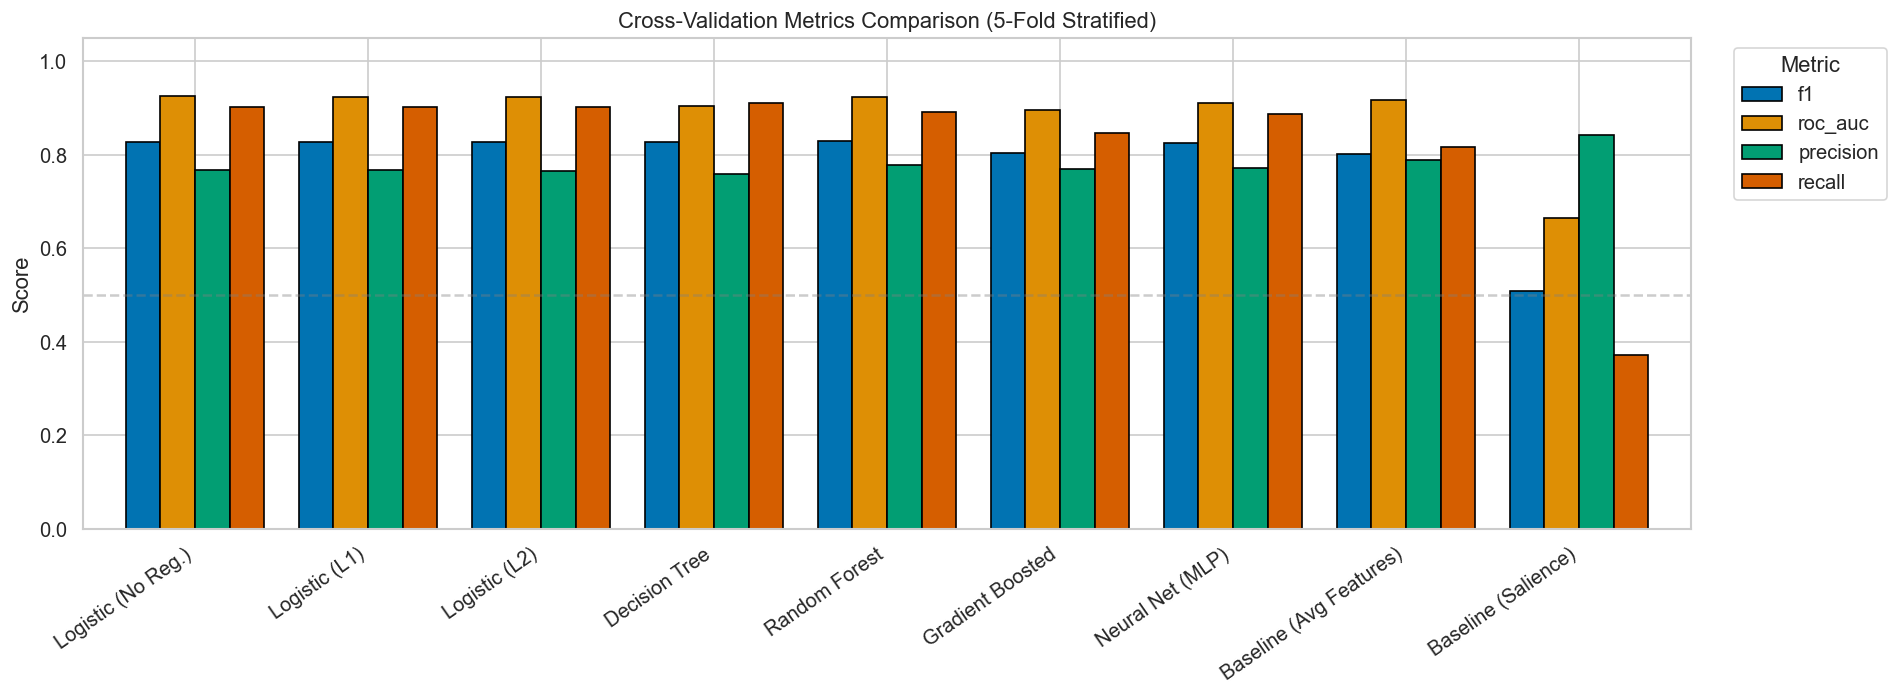

In [38]:
metrics_to_plot = ["f1", "roc_auc", "precision", "recall"]
mean_data = pd.DataFrame(
    {
        metric: {name: cv_results[name][metric].mean() for name in cv_results}
        for metric in metrics_to_plot
    }
)

fig, ax = plt.subplots(figsize=(16, 6))
mean_data.plot.bar(ax=ax, edgecolor="black", width=0.8)
ax.set_title("Cross-Validation Metrics Comparison (5-Fold Stratified)")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.4)
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()

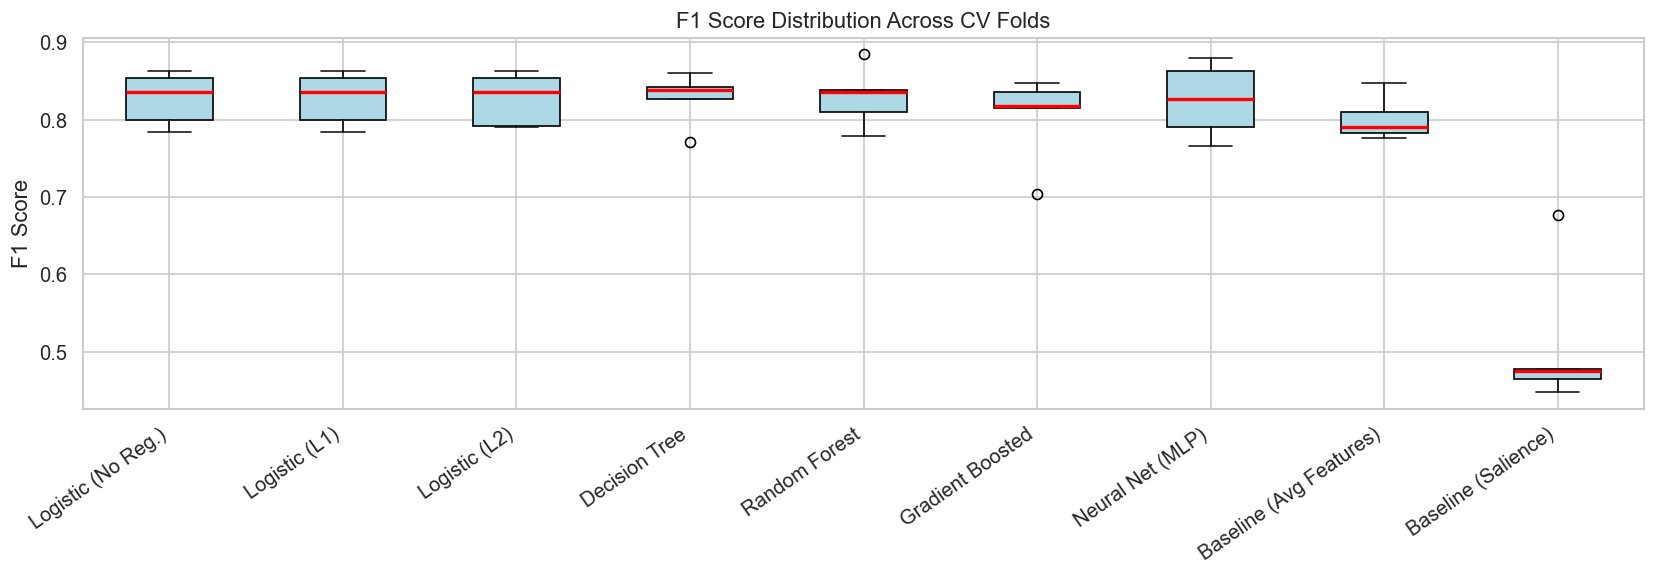

In [39]:
f1_folds = pd.DataFrame(
    {name: cv_results[name]["f1"] for name in cv_results}
)

fig, ax = plt.subplots(figsize=(14, 5))
f1_folds.boxplot(
    ax=ax,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", edgecolor="black"),
    medianprops=dict(color="red", linewidth=2),
)
ax.set_title("F1 Score Distribution Across CV Folds")
ax.set_ylabel("F1 Score")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()

In [40]:
best_model_name = mean_data.loc[list(MODELS.keys()), "f1"].idxmax()
best_f1_folds = f1_folds[best_model_name]

print(f"Best model by mean F1: {best_model_name} ({best_f1_folds.mean():.3f})")
print(f"\nPaired t-test (two-sided) vs. {best_model_name}:")
print("-" * 65)

for name in cv_results:
    if name == best_model_name:
        continue
    other_folds = f1_folds[name]
    t_stat, p_val = stats.ttest_rel(best_f1_folds, other_folds)
    sig = (
        "***"
        if p_val < 0.001
        else "**"
        if p_val < 0.01
        else "*"
        if p_val < 0.05
        else "n.s."
    )
    prefix = "(baseline) " if name in BASELINE_NAMES else ""
    print(f"  vs {prefix}{name:25s}  t={t_stat:+.3f}  p={p_val:.4f}  {sig}")

print(
    f"\nNote: With only 5 folds, these tests have low power. "
    f"Interpret significance cautiously."
)

Best model by mean F1: Random Forest (0.829)

Paired t-test (two-sided) vs. Random Forest:
-----------------------------------------------------------------
  vs Logistic (No Reg.)         t=+0.237  p=0.8243  n.s.
  vs Logistic (L1)              t=+0.237  p=0.8243  n.s.
  vs Logistic (L2)              t=+0.235  p=0.8260  n.s.
  vs Decision Tree              t=+0.253  p=0.8127  n.s.
  vs Gradient Boosted           t=+1.760  p=0.1532  n.s.
  vs Neural Net (MLP)           t=+0.571  p=0.5983  n.s.
  vs (baseline) Baseline (Avg Features)    t=+2.739  p=0.0520  n.s.
  vs (baseline) Baseline (Salience)        t=+10.152  p=0.0005  ***

Note: With only 5 folds, these tests have low power. Interpret significance cautiously.


## 5. Model Explainability

For each model type, we fit on the full training set and produce interpretability plots:
- **Logistic Regression**: coefficient bar plots and odds ratios
- **Decision Tree**: tree visualization and feature importances
- **Ensemble models**: feature importances and partial dependence plots
- **Neural Network**: permutation importance
- **All models**: confusion matrices and ROC curves

In [41]:
fitted_models = {}
for name, model in MODELS.items():
    fitted_models[name] = model.fit(X_train, y_train)

print("All models fitted on full training set.")

All models fitted on full training set.


### 5.1 Logistic Regression: Coefficients and Odds Ratios

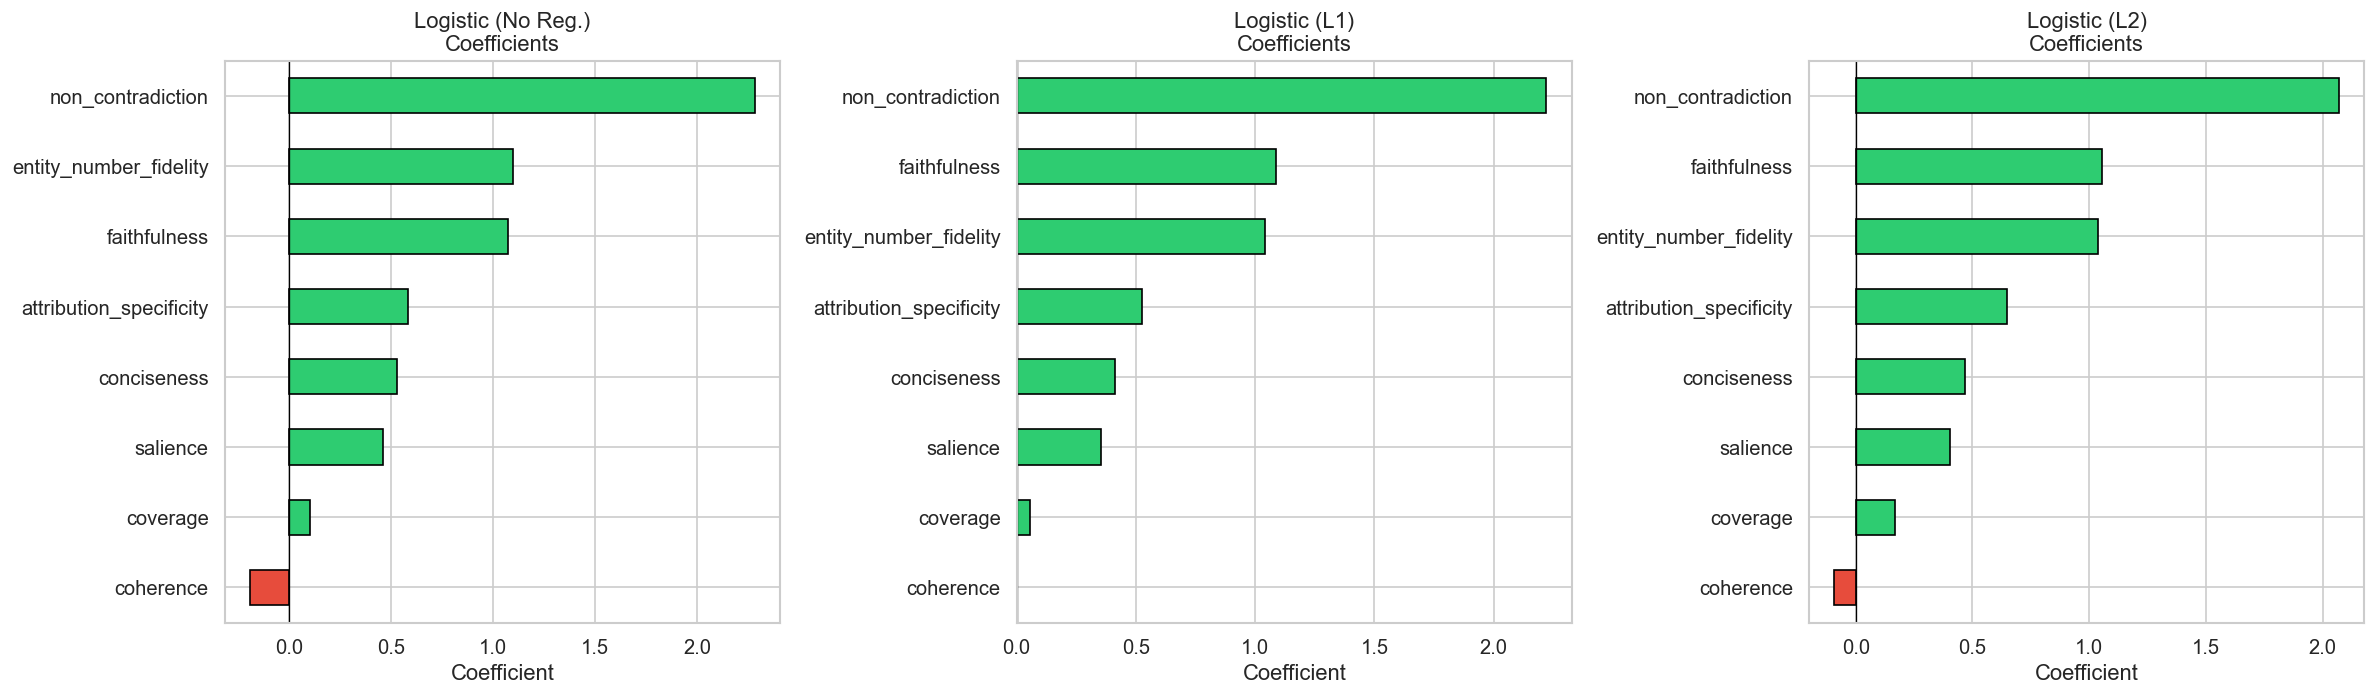

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
lr_names = ["Logistic (No Reg.)", "Logistic (L1)", "Logistic (L2)"]

for idx, name in enumerate(lr_names):
    model = fitted_models[name]
    coefs = pd.Series(model.coef_[0], index=FEATURE_COLS).sort_values()
    colors = ["#e74c3c" if v < 0 else "#2ecc71" for v in coefs]
    coefs.plot.barh(ax=axes[idx], color=colors, edgecolor="black")
    axes[idx].set_title(f"{name}\nCoefficients")
    axes[idx].axvline(x=0, color="black", linewidth=0.8)
    axes[idx].set_xlabel("Coefficient")

plt.tight_layout()
plt.show()

In [43]:
lr_unreg = fitted_models["Logistic (No Reg.)"]
odds_df = (
    pd.DataFrame(
        {
            "Feature": FEATURE_COLS,
            "Coefficient": lr_unreg.coef_[0],
            "Odds Ratio": np.exp(lr_unreg.coef_[0]),
        }
    )
    .sort_values("Odds Ratio", ascending=False)
    .reset_index(drop=True)
)
odds_df["Interpretation"] = odds_df["Odds Ratio"].apply(
    lambda x: (
        f"{x:.2f}x more likely to PASS"
        if x > 1
        else f"{1 / x:.2f}x more likely to FAIL"
    )
)
print("Odds Ratios (Unregularized Logistic Regression):")
print(odds_df.to_string(index=False))

Odds Ratios (Unregularized Logistic Regression):
                Feature  Coefficient  Odds Ratio            Interpretation
      non_contradiction     2.283856    9.814450 9.81x more likely to PASS
 entity_number_fidelity     1.096226    2.992850 2.99x more likely to PASS
           faithfulness     1.071761    2.920517 2.92x more likely to PASS
attribution_specificity     0.581962    1.789546 1.79x more likely to PASS
            conciseness     0.531347    1.701222 1.70x more likely to PASS
               salience     0.462123    1.587440 1.59x more likely to PASS
               coverage     0.101255    1.106558 1.11x more likely to PASS
              coherence    -0.192153    0.825180 1.21x more likely to FAIL


### 5.2 Decision Tree Visualization

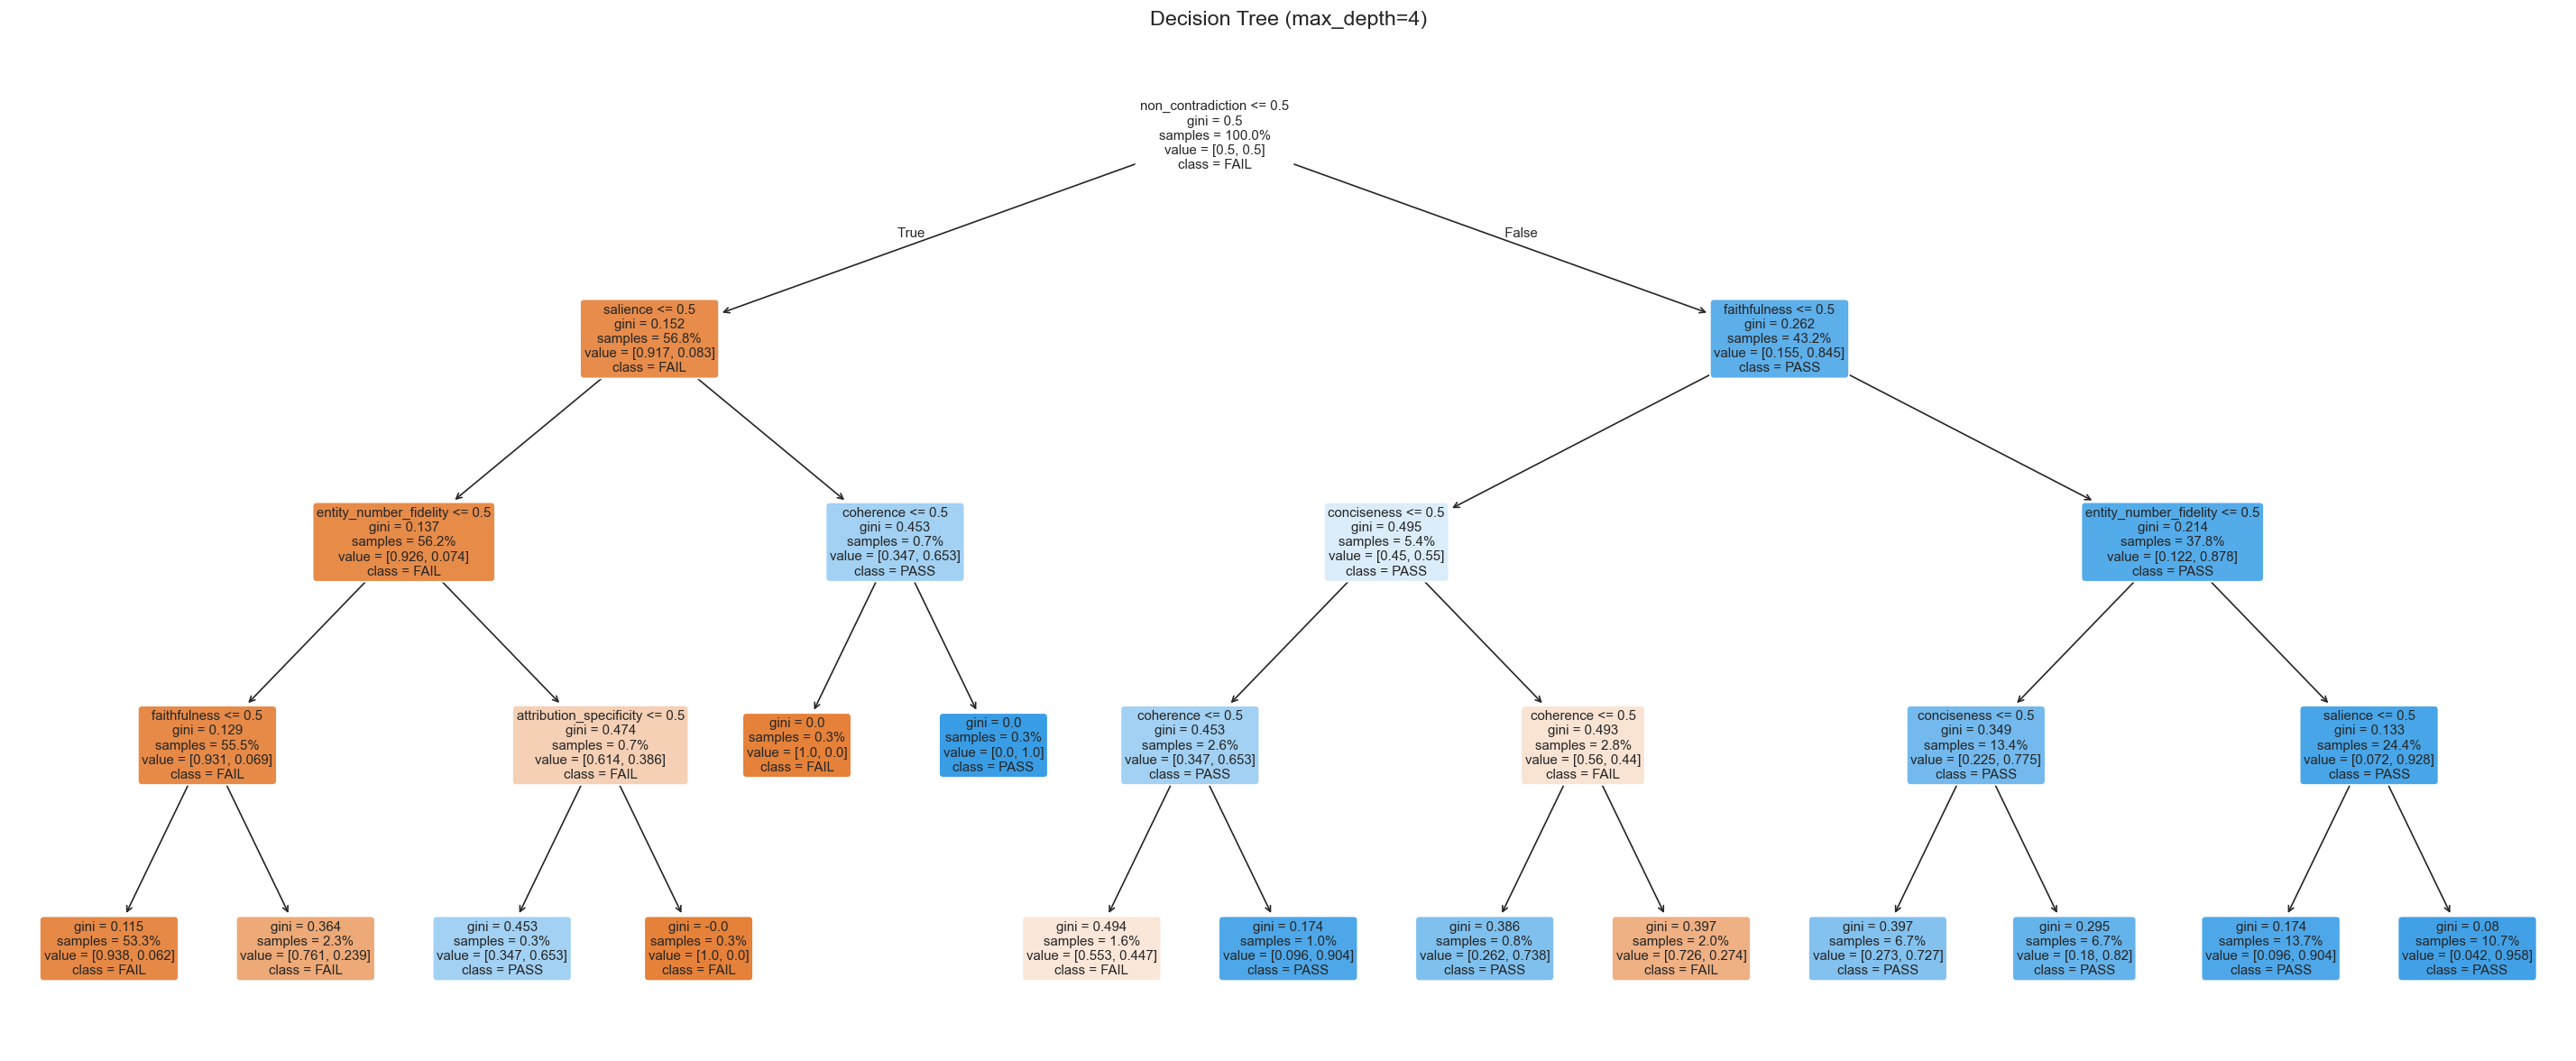

In [44]:
dt_model = fitted_models["Decision Tree"]

fig, ax = plt.subplots(figsize=(24, 10))
plot_tree(
    dt_model,
    feature_names=FEATURE_COLS,
    class_names=["FAIL", "PASS"],
    filled=True,
    rounded=True,
    fontsize=9,
    ax=ax,
    impurity=True,
    proportion=True,
)
ax.set_title("Decision Tree (max_depth=4)", fontsize=14)
plt.tight_layout()
plt.show()

### 5.3 Feature Importances (Tree-Based Models)

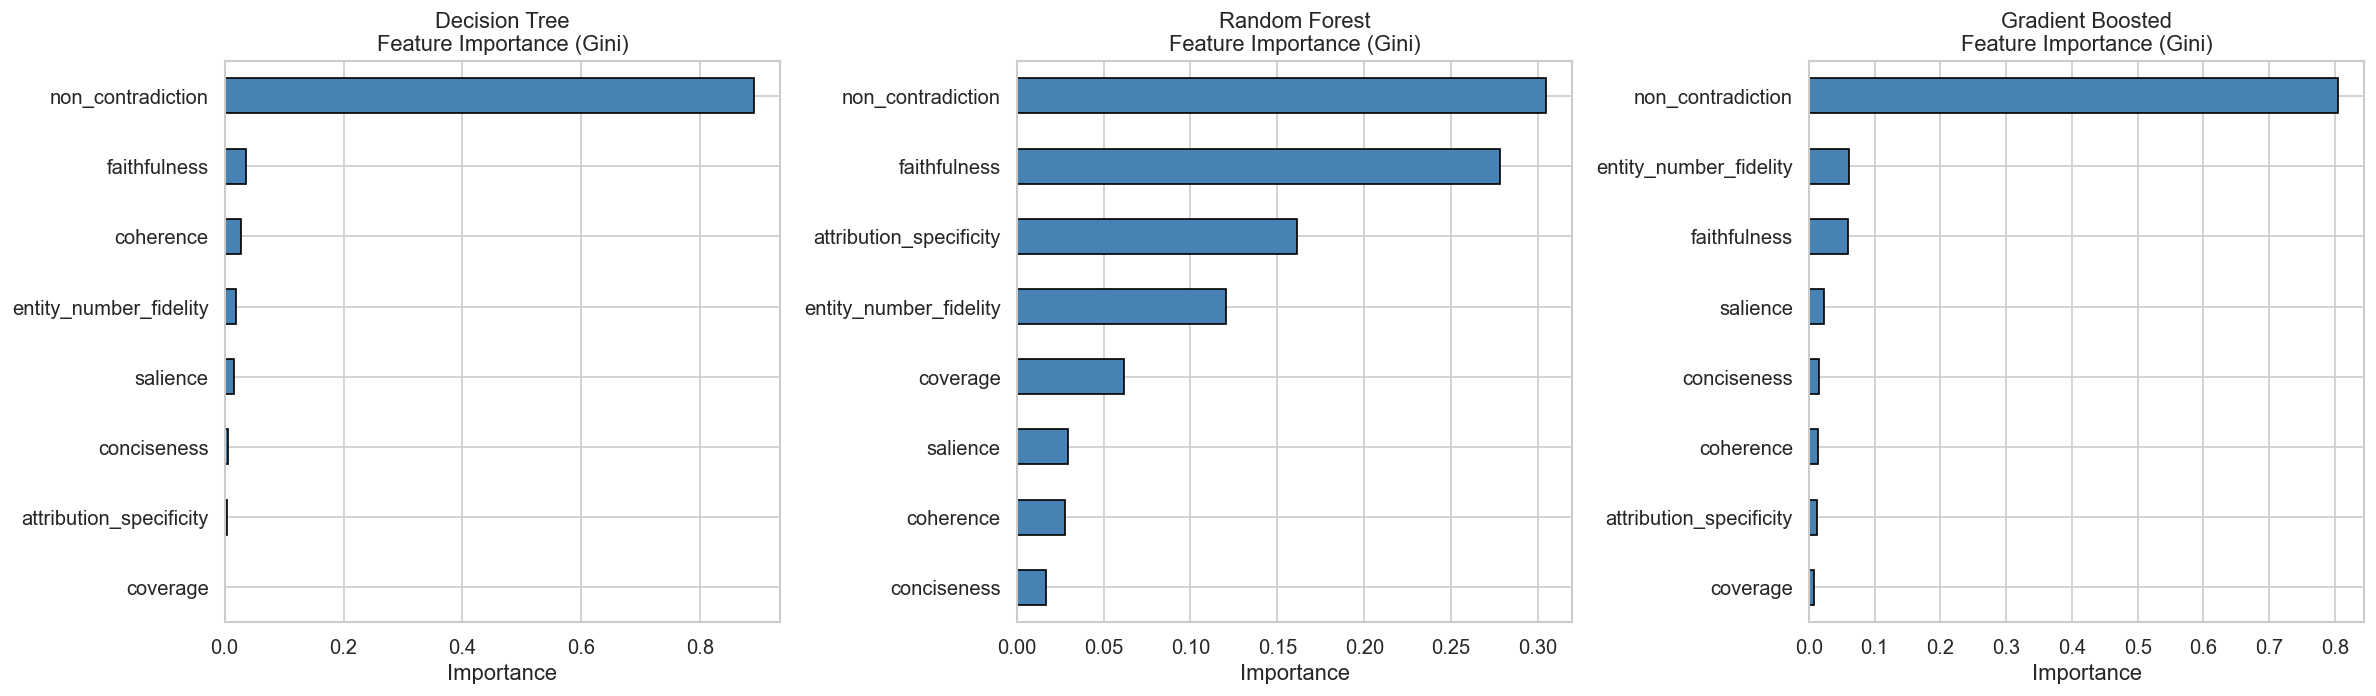

In [45]:
tree_models = ["Decision Tree", "Random Forest", "Gradient Boosted"]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, name in enumerate(tree_models):
    model = fitted_models[name]
    importances = pd.Series(
        model.feature_importances_, index=FEATURE_COLS
    ).sort_values(ascending=True)
    importances.plot.barh(ax=axes[idx], color="steelblue", edgecolor="black")
    axes[idx].set_title(f"{name}\nFeature Importance (Gini)")
    axes[idx].set_xlabel("Importance")

plt.tight_layout()
plt.show()

### 5.4 Partial Dependence Plots (Ensemble Models)

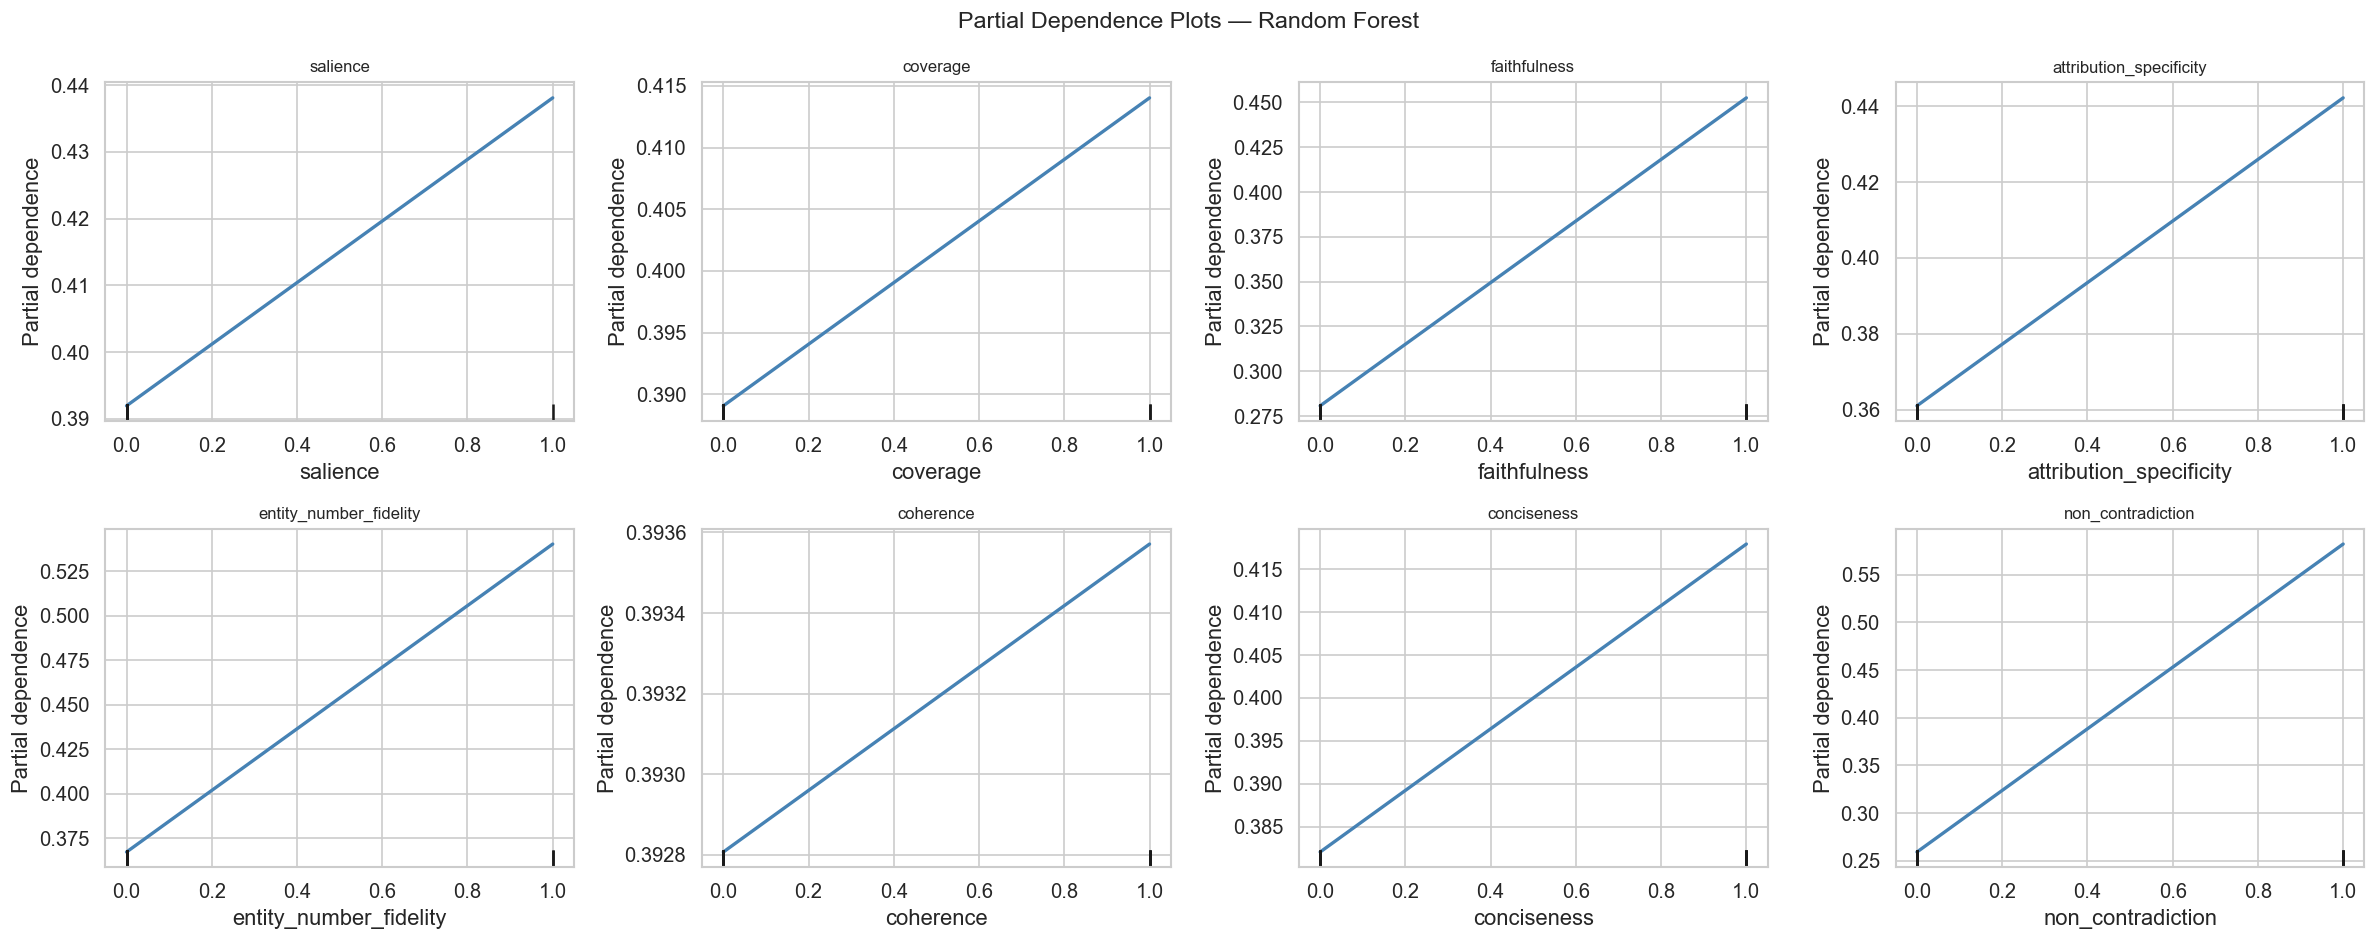

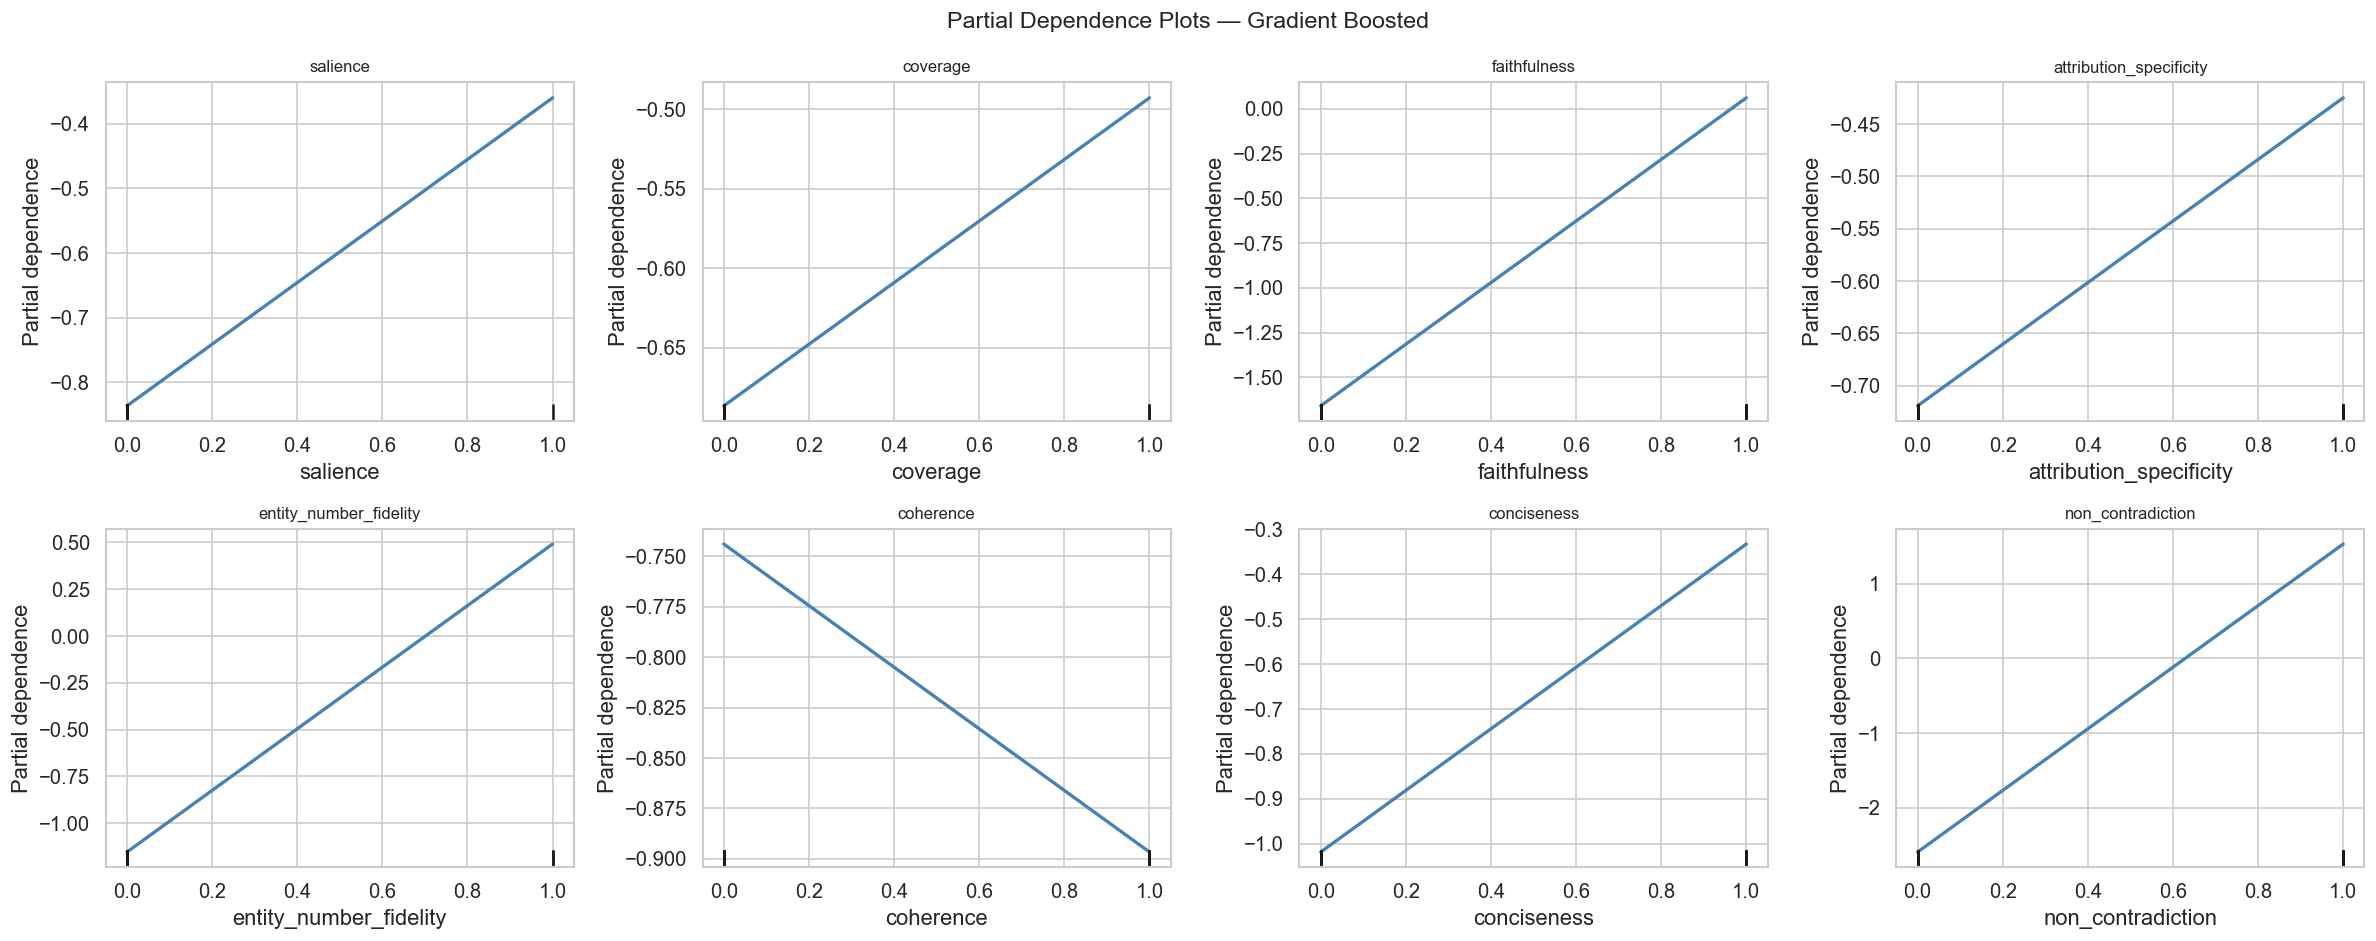

In [46]:
for name in ["Random Forest", "Gradient Boosted"]:
    model = fitted_models[name]
    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    axes_flat = axes.flatten()

    for idx, feature in enumerate(FEATURE_COLS):
        PartialDependenceDisplay.from_estimator(
            model,
            X_train,
            [idx],
            ax=axes_flat[idx],
            kind="average",
            line_kw={"color": "steelblue", "linewidth": 2},
        )
        axes_flat[idx].set_title(feature, fontsize=10)

    fig.suptitle(f"Partial Dependence Plots — {name}", fontsize=14)
    plt.tight_layout()
    plt.show()

### 5.5 Neural Network: Permutation Importance

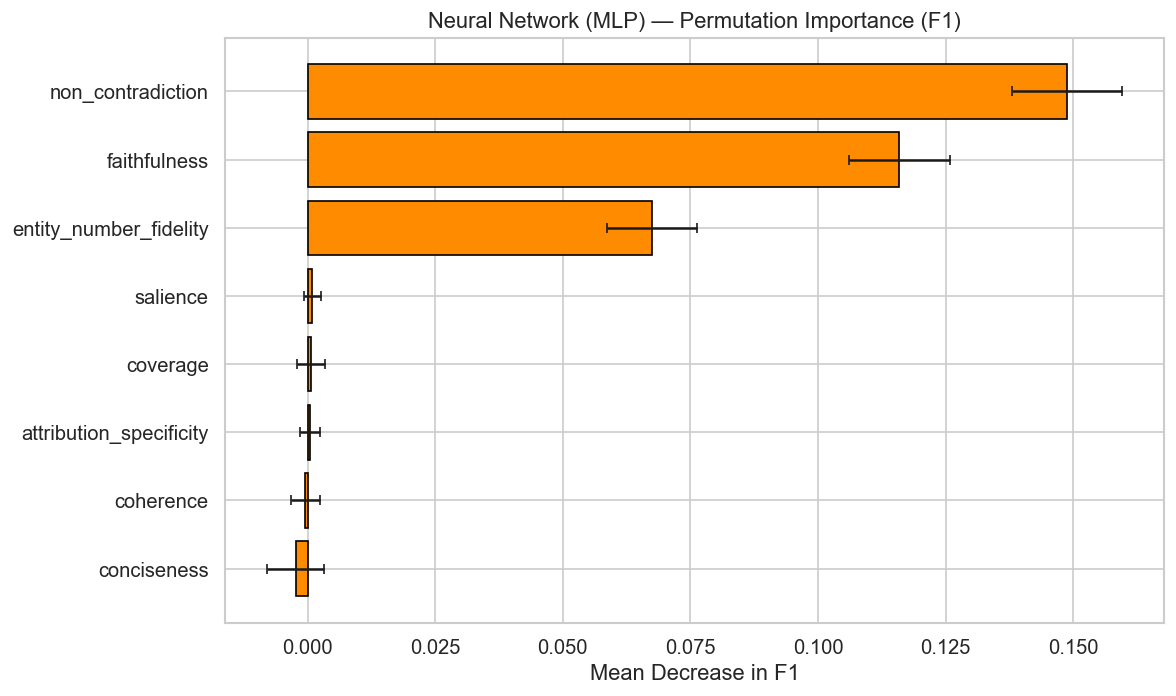

In [47]:
mlp_model = fitted_models["Neural Net (MLP)"]

perm_result = permutation_importance(
    mlp_model,
    X_train,
    y_train,
    n_repeats=30,
    random_state=RANDOM_STATE,
    scoring="f1",
    n_jobs=-1,
)

perm_df = pd.DataFrame(
    {
        "Feature": FEATURE_COLS,
        "Importance Mean": perm_result.importances_mean,
        "Importance Std": perm_result.importances_std,
    }
).sort_values("Importance Mean", ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(
    perm_df["Feature"],
    perm_df["Importance Mean"],
    xerr=perm_df["Importance Std"],
    color="darkorange",
    edgecolor="black",
    capsize=3,
)
ax.set_title("Neural Network (MLP) \u2014 Permutation Importance (F1)")
ax.set_xlabel("Mean Decrease in F1")
plt.tight_layout()
plt.show()

### 5.6 Confusion Matrices (Cross-Validated Predictions)

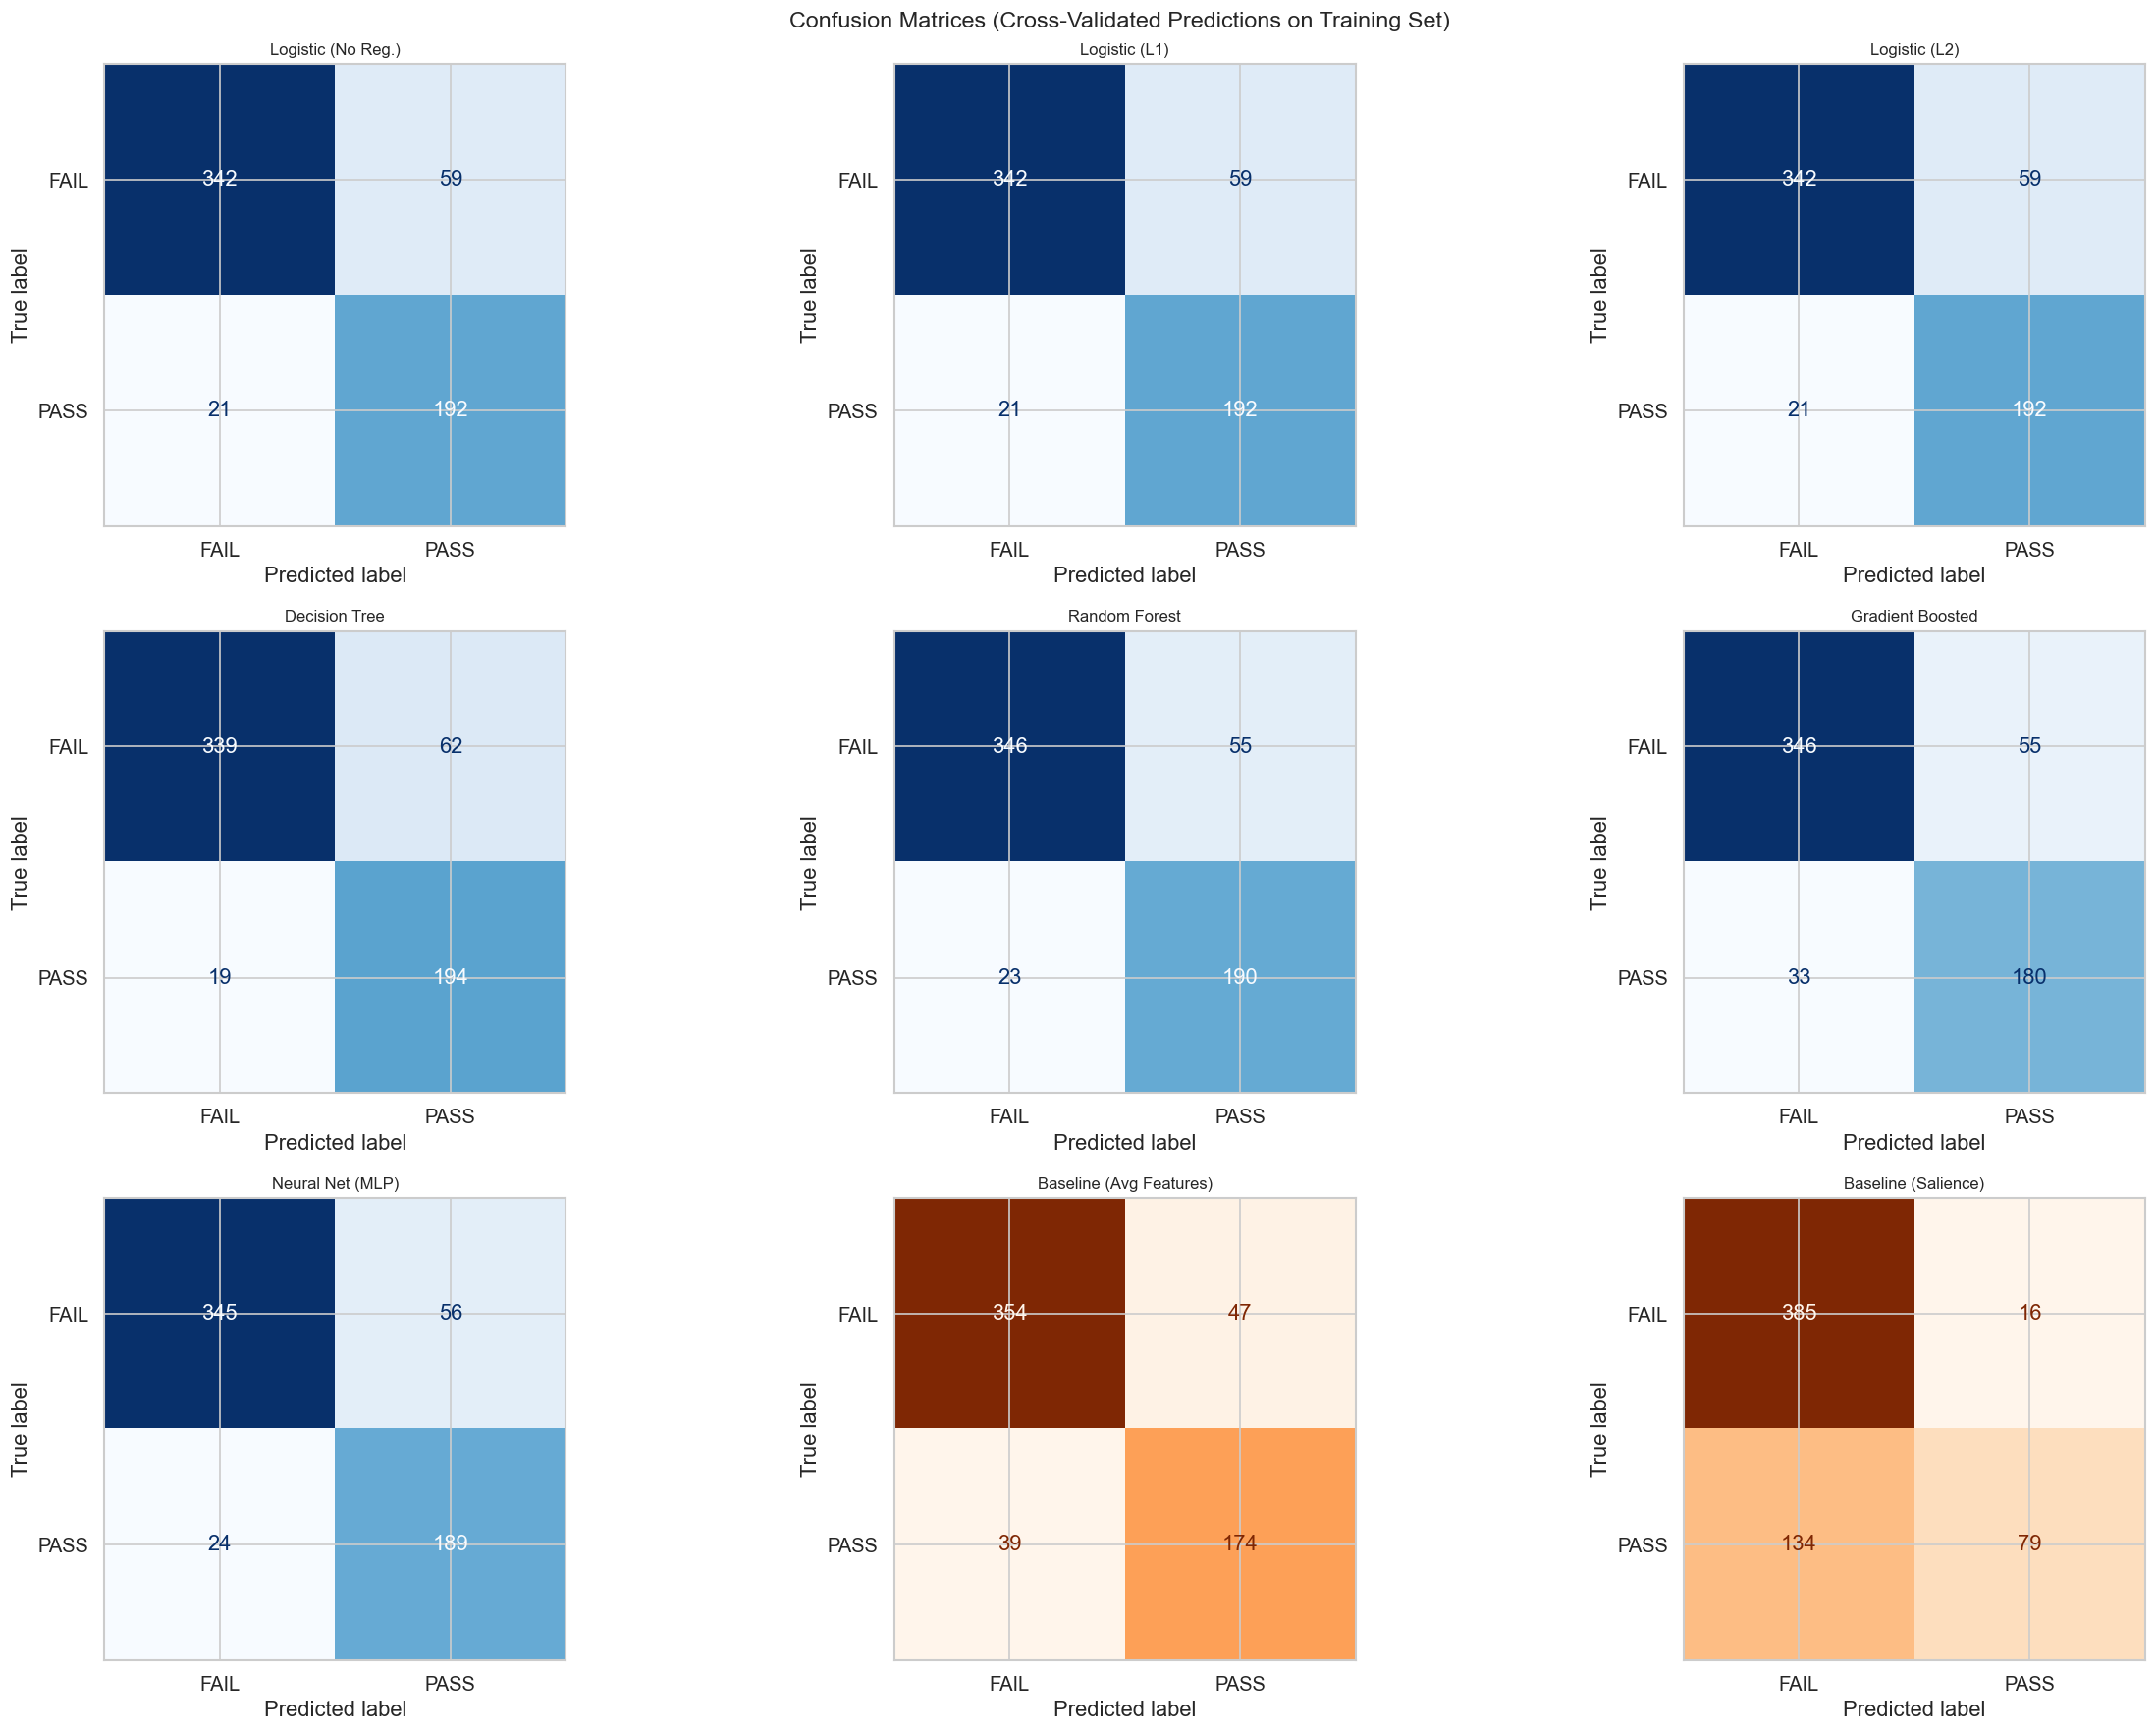

In [48]:
n_total = len(MODELS) + len(BASELINE_NAMES)
ncols = 3
nrows = (n_total + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 5 * nrows))
axes_flat = axes.flatten()

idx = 0
# Sklearn models
for name, model in MODELS.items():
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)
    ConfusionMatrixDisplay.from_predictions(
        y_train,
        y_pred_cv,
        display_labels=["FAIL", "PASS"],
        ax=axes_flat[idx],
        cmap="Blues",
        colorbar=False,
    )
    axes_flat[idx].set_title(name, fontsize=10)
    idx += 1

# Baselines (use pre-computed predictions)
for name in BASELINE_NAMES:
    ConfusionMatrixDisplay.from_predictions(
        baseline_cv_preds[name]["y_true"],
        baseline_cv_preds[name]["y_pred"],
        display_labels=["FAIL", "PASS"],
        ax=axes_flat[idx],
        cmap="Oranges",
        colorbar=False,
    )
    axes_flat[idx].set_title(f"{name}", fontsize=10)
    idx += 1

# Hide unused subplots
for j in range(idx, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.suptitle(
    "Confusion Matrices (Cross-Validated Predictions on Training Set)",
    fontsize=14,
)
plt.tight_layout()
plt.show()

### 5.7 ROC Curves

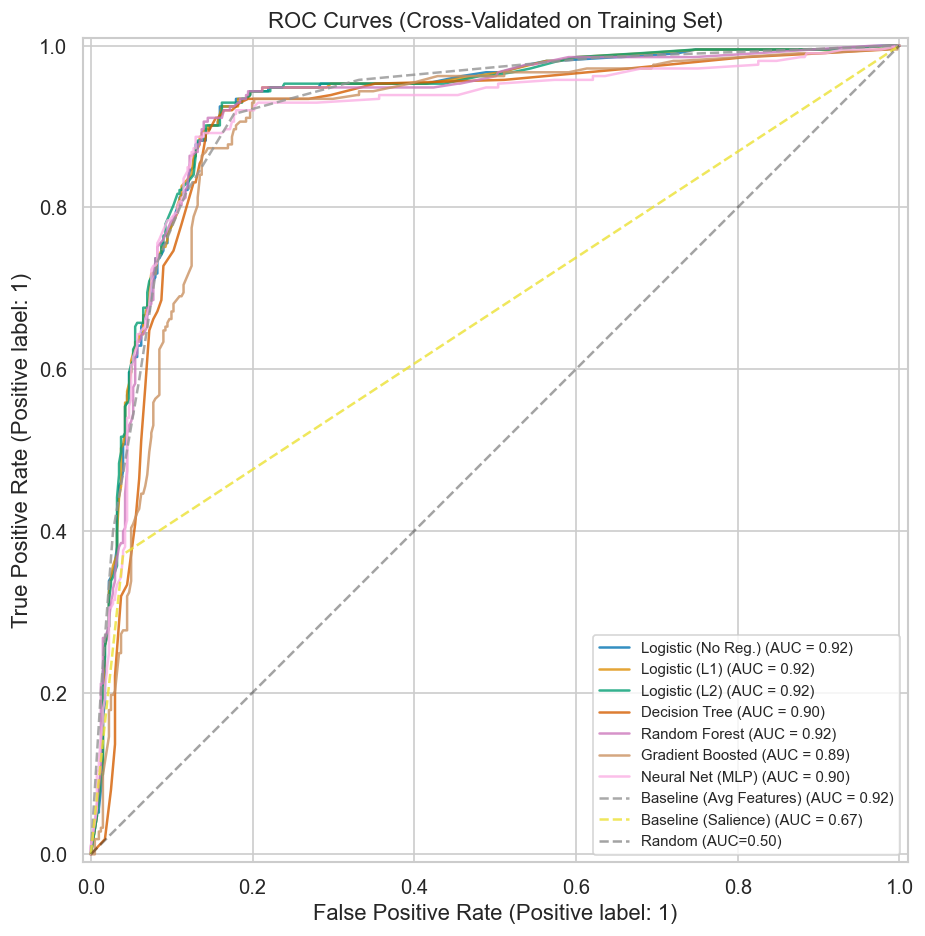

In [49]:
fig, ax = plt.subplots(figsize=(10, 8))

# ML models (solid lines)
for name, model in MODELS.items():
    y_proba_cv = cross_val_predict(
        model, X_train, y_train, cv=cv, method="predict_proba"
    )[:, 1]
    RocCurveDisplay.from_predictions(
        y_train,
        y_proba_cv,
        name=name,
        ax=ax,
        alpha=0.8,
    )

# Baselines (dashed lines)
for name in BASELINE_NAMES:
    RocCurveDisplay.from_predictions(
        baseline_cv_preds[name]["y_true"],
        baseline_cv_preds[name]["y_proba"],
        name=name,
        ax=ax,
        alpha=0.8,
        linestyle="--",
    )

ax.plot([0, 1], [0, 1], "k--", alpha=0.4, label="Random (AUC=0.50)")
ax.set_title("ROC Curves (Cross-Validated on Training Set)")
ax.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()

## 6. Unified Feature Importance Comparison

Compare feature importance rankings across all model types:
- Absolute coefficients for logistic regression
- Gini importance for tree-based models
- Permutation importance for the neural network

All values are min-max normalized to [0, 1] for comparability.

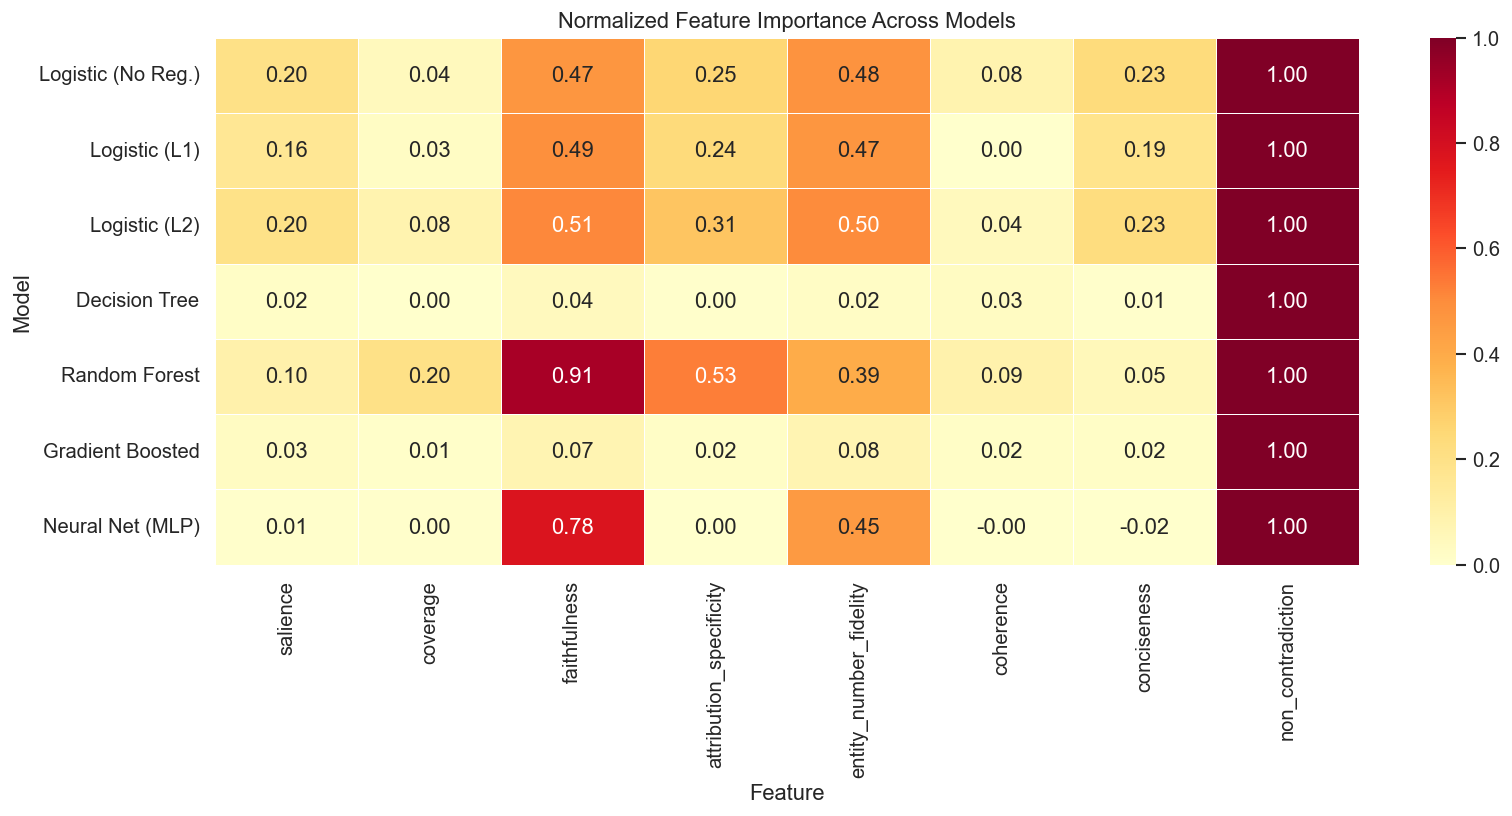


Median normalized importance (across all models):
  non_contradiction               1.000
  faithfulness                    0.490
  entity_number_fidelity          0.453
  attribution_specificity         0.237
  salience                        0.097
  conciseness                     0.055
  coherence                       0.031
  coverage                        0.025


In [50]:
importance_dict = {}

# Logistic regression: absolute coefficients
for name in ["Logistic (No Reg.)", "Logistic (L1)", "Logistic (L2)"]:
    importance_dict[name] = np.abs(fitted_models[name].coef_[0])

# Tree-based: Gini feature importances
for name in ["Decision Tree", "Random Forest", "Gradient Boosted"]:
    importance_dict[name] = fitted_models[name].feature_importances_

# MLP: permutation importance
importance_dict["Neural Net (MLP)"] = perm_result.importances_mean

# Build DataFrame and normalize each row to [0, 1]
imp_df = pd.DataFrame(importance_dict, index=FEATURE_COLS).T
imp_normalized = imp_df.div(imp_df.max(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(
    imp_normalized,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    linewidths=0.5,
    ax=ax,
    vmin=0,
    vmax=1,
    square=False,
)
ax.set_title("Normalized Feature Importance Across Models")
ax.set_ylabel("Model")
ax.set_xlabel("Feature")
plt.tight_layout()
plt.show()

print("\nMedian normalized importance (across all models):")
median_imp = imp_normalized.median(axis=0).sort_values(ascending=False)
for feat, val in median_imp.items():
    print(f"  {feat:30s}  {val:.3f}")

## 7. Final Model Evaluation on Held-Out Test Set

Based on cross-validation results, we select the best model by mean F1 score,
fit it on the full training set, and evaluate on the held-out test set.

In [51]:
# Select best model (from ML models only, not baselines)
cv_f1_means = {name: cv_results[name]["f1"].mean() for name in MODELS}
best_name = max(cv_f1_means, key=cv_f1_means.get)

print(f"Best model by CV F1: {best_name} (F1 = {cv_f1_means[best_name]:.3f})")

# Show all scores including baselines
all_f1_means = {name: cv_results[name]["f1"].mean() for name in cv_results}
print(f"\nAll CV F1 scores (including baselines):")
for name, f1_mean in sorted(all_f1_means.items(), key=lambda x: -x[1]):
    tag = " (baseline)" if name in BASELINE_NAMES else ""
    print(f"  {name:30s}  {f1_mean:.3f}{tag}")

best_model = fitted_models[best_name]

Best model by CV F1: Random Forest (F1 = 0.829)

All CV F1 scores (including baselines):
  Random Forest                   0.829
  Decision Tree                   0.828
  Logistic (No Reg.)              0.827
  Logistic (L1)                   0.827
  Logistic (L2)                   0.827
  Neural Net (MLP)                0.825
  Gradient Boosted                0.804
  Baseline (Avg Features)         0.801 (baseline)
  Baseline (Salience)             0.508 (baseline)


In [52]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"=== Test Set Results: {best_name} ===")
print()
print(
    classification_report(
        y_test, y_pred, target_names=["FAIL", "PASS"], digits=3
    )
)
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

=== Test Set Results: Random Forest ===

              precision    recall  f1-score   support

        FAIL      0.955     0.840     0.894       100
        PASS      0.758     0.926     0.833        54

    accuracy                          0.870       154
   macro avg      0.856     0.883     0.863       154
weighted avg      0.885     0.870     0.872       154

ROC AUC: 0.922


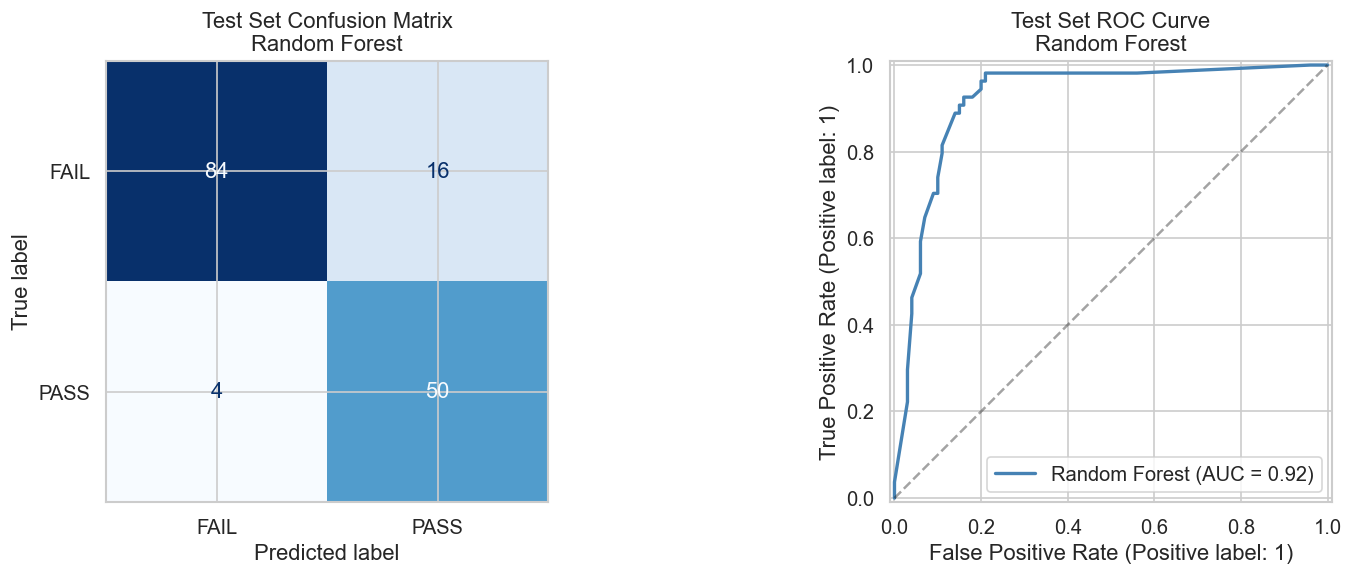

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["FAIL", "PASS"],
    ax=axes[0],
    cmap="Blues",
    colorbar=False,
)
axes[0].set_title(f"Test Set Confusion Matrix\n{best_name}")

RocCurveDisplay.from_predictions(
    y_test,
    y_proba,
    name=best_name,
    ax=axes[1],
    color="steelblue",
    linewidth=2,
)
axes[1].plot([0, 1], [0, 1], "k--", alpha=0.4)
axes[1].set_title(f"Test Set ROC Curve\n{best_name}")

plt.tight_layout()
plt.show()

### Error Analysis

In [54]:
test_df = X_test.copy()
test_df["y_true"] = y_test.values
test_df["y_pred"] = y_pred
test_df["y_proba"] = y_proba
test_df["correct"] = test_df["y_true"] == test_df["y_pred"]

fp = test_df[(test_df["y_true"] == 0) & (test_df["y_pred"] == 1)]
fn = test_df[(test_df["y_true"] == 1) & (test_df["y_pred"] == 0)]
tp = test_df[(test_df["y_true"] == 1) & (test_df["y_pred"] == 1)]
tn = test_df[(test_df["y_true"] == 0) & (test_df["y_pred"] == 0)]

print(f"Test set breakdown:")
print(f"  True Positives:  {len(tp)}")
print(f"  True Negatives:  {len(tn)}")
print(f"  False Positives: {len(fp)} (predicted PASS, actually FAIL)")
print(f"  False Negatives: {len(fn)} (predicted FAIL, actually PASS)")

if len(fp) > 0 and len(tn) > 0:
    print(f"\n--- Feature means: False Positives vs True Negatives ---")
    comparison = pd.DataFrame(
        {
            "FP mean": fp[FEATURE_COLS].mean(),
            "TN mean": tn[FEATURE_COLS].mean(),
            "Diff (FP - TN)": fp[FEATURE_COLS].mean()
            - tn[FEATURE_COLS].mean(),
        }
    ).sort_values("Diff (FP - TN)", ascending=False)
    print(comparison.to_string())

if len(fn) > 0 and len(tp) > 0:
    print(f"\n--- Feature means: False Negatives vs True Positives ---")
    comparison2 = pd.DataFrame(
        {
            "FN mean": fn[FEATURE_COLS].mean(),
            "TP mean": tp[FEATURE_COLS].mean(),
            "Diff (FN - TP)": fn[FEATURE_COLS].mean()
            - tp[FEATURE_COLS].mean(),
        }
    ).sort_values("Diff (FN - TP)", ascending=False)
    print(comparison2.to_string())

Test set breakdown:
  True Positives:  50
  True Negatives:  84
  False Positives: 16 (predicted PASS, actually FAIL)
  False Negatives: 4 (predicted FAIL, actually PASS)

--- Feature means: False Positives vs True Negatives ---
                         FP mean   TN mean  Diff (FP - TN)
non_contradiction         0.9375  0.023810        0.913690
attribution_specificity   1.0000  0.107143        0.892857
faithfulness              0.8750  0.023810        0.851190
entity_number_fidelity    0.5625  0.000000        0.562500
coherence                 0.6875  0.250000        0.437500
salience                  0.3750  0.000000        0.375000
coverage                  0.3750  0.000000        0.375000
conciseness               0.6875  0.357143        0.330357

--- Feature means: False Negatives vs True Positives ---
                         FN mean  TP mean  Diff (FN - TP)
faithfulness                0.75     0.96           -0.21
salience                    0.00     0.40           -0.40
entity_n

## 8. Summary

In [55]:
print("=" * 70)
print("EXPERIMENT SUMMARY")
print("=" * 70)

print(f"\nDataset: {DATA_PATH.name}")
print(
    f"  Samples: {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})"
)
print(f"  Features: {len(FEATURE_COLS)} binary LLM judge scores")
print(f"  Class balance: {y.mean():.1%} PASS / {1 - y.mean():.1%} FAIL")

print(f"\nBest model: {best_name}")
print(f"  CV F1:       {cv_f1_means[best_name]:.3f}")
print(f"  Test F1:     {f1_score(y_test, y_pred):.3f}")
print(f"  Test AUC:    {roc_auc_score(y_test, y_proba):.3f}")
print(f"  Test Acc:    {accuracy_score(y_test, y_pred):.3f}")

print(f"\nMost predictive features (median normalized importance):")
for i, (feat, val) in enumerate(median_imp.head(3).items()):
    print(f"  {i + 1}. {feat} ({val:.3f})")

print("=" * 70)

EXPERIMENT SUMMARY

Dataset: summarization_frank_features.csv
  Samples: 768 (Train: 614, Test: 154)
  Features: 8 binary LLM judge scores
  Class balance: 34.8% PASS / 65.2% FAIL

Best model: Random Forest
  CV F1:       0.829
  Test F1:     0.833
  Test AUC:    0.922
  Test Acc:    0.870

Most predictive features (median normalized importance):
  1. non_contradiction (1.000)
  2. faithfulness (0.490)
  3. entity_number_fidelity (0.453)


### Key Findings

1. **Most predictive features**: The features that consistently rank highest across all model
   types reveal which quality dimensions dominate the overall quality judgment.

2. **Model performance**: With only 8 binary features, simpler models (logistic regression,
   decision trees) often perform comparably to complex ones, validating that the feature space
   is well-structured for classification.

3. **Practical implications**: A lightweight classifier on 8 binary LLM judge features can
   effectively replicate the overall quality judgment, making it feasible to build a fast,
   interpretable quality gate without running the full LLM judge pipeline repeatedly.